In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

# from utils import *
# from usad import *

## Utils


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.metrics import roc_curve,roc_auc_score

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        print('Cuda Available!!!')
        return torch.device('cuda')
    else:
        print('On CPU...')

        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def plot_history(history):
    losses1 = [x['val_loss1'] for x in history]
    losses2 = [x['val_loss2'] for x in history]
    plt.plot(losses1, '-x', label="loss1")
    plt.plot(losses2, '-x', label="loss2")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.show()

def histogram(y_test,y_pred):
    plt.figure(figsize=(12,6))
    plt.hist([y_pred[y_test==0],
              y_pred[y_test==1]],
            bins=20,
            color = ['#82E0AA','#EC7063'],stacked=True)
    plt.title("Results",size=20)
    plt.grid()
    plt.show()

def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

def confusion_matrix(target, predicted, perc=False):

    data = {'y_Actual':    target,
            'y_Predicted': predicted
            }
    df = pd.DataFrame(data, columns=['y_Predicted','y_Actual'])
    confusion_matrix = pd.crosstab(df['y_Predicted'], df['y_Actual'], rownames=['Predicted'], colnames=['Actual'])

    if perc:
        sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%', cmap='Blues')
    else:
        sns.heatmap(confusion_matrix, annot=True, fmt='d')
    plt.show()

## USAD model

In [5]:
import torch
import torch.nn as nn

# from utils import *
device = get_default_device()

class Encoder(nn.Module):
  def __init__(self, in_size, latent_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size, int(in_size/2))
    self.linear2 = nn.Linear(int(in_size/2), int(in_size/4))
    self.linear3 = nn.Linear(int(in_size/4), latent_size)
    self.relu = nn.ReLU(True)

  def forward(self, w):
    out = self.linear1(w)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    out = self.linear3(out)
    z = self.relu(out)
    return z

class Decoder(nn.Module):
  def __init__(self, latent_size, out_size):
    super().__init__()
    self.linear1 = nn.Linear(latent_size, int(out_size/4))
    self.linear2 = nn.Linear(int(out_size/4), int(out_size/2))
    self.linear3 = nn.Linear(int(out_size/2), out_size)
    self.relu = nn.ReLU(True)
    self.sigmoid = nn.Sigmoid()

  def forward(self, z):
    out = self.linear1(z)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    out = self.linear3(out)
    w = self.sigmoid(out)
    return w

class UsadModel(nn.Module):
  def __init__(self, w_size, z_size):
    super().__init__()
    self.encoder = Encoder(w_size, z_size)
    self.decoder1 = Decoder(z_size, w_size)
    self.decoder2 = Decoder(z_size, w_size)

  def training_step(self, batch, n):
    z = self.encoder(batch)
    w1 = self.decoder1(z)
    w2 = self.decoder2(z)
    w3 = self.decoder2(self.encoder(w1))
    loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
    loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
    return loss1,loss2

  def validation_step(self, batch, n):
    with torch.no_grad():
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
        loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
    return {'val_loss1': loss1, 'val_loss2': loss2}

  def validation_epoch_end(self, outputs):
    batch_losses1 = [x['val_loss1'] for x in outputs]
    epoch_loss1 = torch.stack(batch_losses1).mean()
    batch_losses2 = [x['val_loss2'] for x in outputs]
    epoch_loss2 = torch.stack(batch_losses2).mean()
    return {'val_loss1': epoch_loss1.item(), 'val_loss2': epoch_loss2.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2']))

def evaluate(model, val_loader, n):
    outputs = [model.validation_step(to_device(batch,device), n) for [batch] in val_loader]
    return model.validation_epoch_end(outputs)

def training(epochs, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer1 = opt_func(list(model.encoder.parameters())+list(model.decoder1.parameters()))
    optimizer2 = opt_func(list(model.encoder.parameters())+list(model.decoder2.parameters()))
    for epoch in range(epochs):
        print(f'Epoch ', epoch)
        for [batch] in train_loader:
            batch=to_device(batch,device)

            #Train AE1
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss1.backward()
            optimizer1.step()
            optimizer1.zero_grad()


            #Train AE2
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss2.backward()
            optimizer2.step()
            optimizer2.zero_grad()


        result = evaluate(model, val_loader, epoch+1)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def testing(model, test_loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for [batch] in test_loader:
            batch=to_device(batch,device)
            w1=model.decoder1(model.encoder(batch))
            w2=model.decoder2(model.encoder(w1))
            results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

Cuda Available!!!


## Normal

In [32]:
# normal = pd.read_csv("../Normal.csv", nrows=10000)
# normal = pd.read_csv('../Preprocessing/preprocessed_normal_data.csv', nrows=10000)
normal = pd.read_csv('../Preprocessing/normal_data_with_pca.csv', nrows=10000)

normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

(10000, 50)

In [33]:
# Transform all columns into float64
for i in list(normal):
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)
normal

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49,PCA_50
0,-0.765288,0.680210,-0.208207,0.167559,-0.305226,-0.288559,0.080335,-0.083534,0.640262,0.261579,...,-0.012005,0.088227,0.999706,2.360443e-12,9.931964e-13,-4.022981e-13,1.690585e-12,-1.559091e-12,6.365321e-14,-5.291445e-13
1,-0.764532,0.679727,-0.205827,0.167724,-0.305651,-0.288532,0.080468,-0.084240,0.640245,0.261515,...,-0.012000,0.088227,0.999706,2.360443e-12,9.931964e-13,-4.022981e-13,1.690598e-12,-1.559091e-12,6.365321e-14,-5.291445e-13
2,-0.764098,0.678547,-0.202614,0.167957,-0.306274,-0.288656,0.080641,-0.084925,0.640409,0.261429,...,-0.012001,0.088227,0.999706,2.360429e-12,9.931964e-13,-4.022981e-13,1.690585e-12,-1.559091e-12,6.365321e-14,-5.291445e-13
3,-0.763698,0.678123,-0.200553,0.168150,-0.306551,-0.288655,0.080737,-0.085728,0.640386,0.261433,...,-0.012001,0.088227,0.999706,2.360429e-12,9.931964e-13,-4.022981e-13,1.690585e-12,-1.559091e-12,6.365321e-14,-5.291445e-13
4,-0.763604,0.678006,-0.199924,0.168249,-0.306638,-0.288636,0.080804,-0.086121,0.640387,0.261449,...,-0.011989,0.088227,0.999706,2.360415e-12,9.931964e-13,-4.022981e-13,1.690585e-12,-1.559091e-12,6.365321e-14,-5.291445e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.479142,-0.303036,-0.370259,-0.476664,0.088241,-0.036851,0.027737,-0.165812,0.010153,-0.019924,...,-0.005144,0.005129,0.999710,2.357605e-12,9.815633e-13,-3.918690e-13,1.697333e-12,-1.566540e-12,5.908048e-14,-5.255501e-13
9996,-0.479060,-0.303040,-0.369688,-0.461190,0.087516,-0.036555,0.027408,-0.166810,0.009536,-0.019981,...,-0.005090,0.005129,0.999710,2.357591e-12,9.815772e-13,-3.918690e-13,1.697333e-12,-1.566540e-12,5.908048e-14,-5.255501e-13
9997,-0.479840,-0.304391,-0.369057,-0.440367,0.086605,-0.036200,0.027322,-0.167092,0.009390,-0.019730,...,-0.005019,0.005128,0.999710,2.357591e-12,9.815494e-13,-3.918412e-13,1.697346e-12,-1.566527e-12,5.908048e-14,-5.255501e-13
9998,-0.480058,-0.305400,-0.367082,-0.424596,0.085620,-0.036027,0.027312,-0.167799,0.009272,-0.019693,...,-0.005019,0.005126,0.999709,2.357591e-12,9.815494e-13,-3.918412e-13,1.697333e-12,-1.566527e-12,5.908048e-14,-5.255501e-13


## Attack

In [34]:
# attack = pd.read_csv("../Attack.csv")#, nrows=1000)
attack = pd.read_csv('../Preprocessing/attack_data_with_pca.csv', nrows=10000)

labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

(10000, 50)

In [35]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

## Windows

In [36]:
import numpy as np


In [37]:
window_size=10


In [38]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(9990, 10, 50)

In [39]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(9990, 10, 50)

# Training


In [40]:
import torch.utils.data as data_utils

BATCH_SIZE = 100
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [53]:
history = training(100,model,train_loader,val_loader)

Epoch  0
Epoch [0], val_loss1: 0.0524, val_loss2: 0.0525
Epoch  1
Epoch [1], val_loss1: 0.1152, val_loss2: -0.0626
Epoch  2
Epoch [2], val_loss1: 0.1552, val_loss2: -0.1208
Epoch  3
Epoch [3], val_loss1: 0.1664, val_loss2: -0.1406
Epoch  4
Epoch [4], val_loss1: 0.1746, val_loss2: -0.1538
Epoch  5
Epoch [5], val_loss1: 0.1825, val_loss2: -0.1652
Epoch  6
Epoch [6], val_loss1: 0.1924, val_loss2: -0.1776
Epoch  7
Epoch [7], val_loss1: 0.1954, val_loss2: -0.1826
Epoch  8
Epoch [8], val_loss1: 0.2009, val_loss2: -0.1894
Epoch  9
Epoch [9], val_loss1: 0.1987, val_loss2: -0.1884
Epoch  10
Epoch [10], val_loss1: 0.2129, val_loss2: -0.2035
Epoch  11
Epoch [11], val_loss1: 0.2127, val_loss2: -0.2041
Epoch  12
Epoch [12], val_loss1: 0.2114, val_loss2: -0.2035
Epoch  13
Epoch [13], val_loss1: 0.2109, val_loss2: -0.2036
Epoch  14
Epoch [14], val_loss1: 0.2121, val_loss2: -0.2053
Epoch  15
Epoch [15], val_loss1: 0.2137, val_loss2: -0.2073
Epoch  16
Epoch [16], val_loss1: 0.2183, val_loss2: -0.2123
E

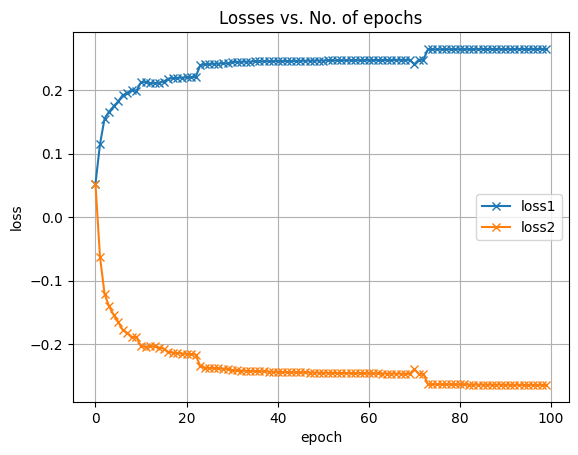

In [54]:
plot_history(history)


In [55]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

model.eval()


UsadModel(
  (encoder): Encoder(
    (linear1): Linear(in_features=500, out_features=250, bias=True)
    (linear2): Linear(in_features=250, out_features=125, bias=True)
    (linear3): Linear(in_features=125, out_features=1000, bias=True)
    (relu): ReLU(inplace=True)
  )
  (decoder1): Decoder(
    (linear1): Linear(in_features=1000, out_features=125, bias=True)
    (linear2): Linear(in_features=125, out_features=250, bias=True)
    (linear3): Linear(in_features=250, out_features=500, bias=True)
    (relu): ReLU(inplace=True)
    (sigmoid): Sigmoid()
  )
  (decoder2): Decoder(
    (linear1): Linear(in_features=1000, out_features=125, bias=True)
    (linear2): Linear(in_features=125, out_features=250, bias=True)
    (linear3): Linear(in_features=250, out_features=500, bias=True)
    (relu): ReLU(inplace=True)
    (sigmoid): Sigmoid()
  )
)

## Saving to ONNX

In [56]:
# Ensure the device is set to the same device as the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the same device as the input
model.to(device)

# Generate dummy input on the same device as the model
dummy_input = torch.randn(1, w_size).to(device)  # Adjust w_size as needed

# Export the encoder to ONNX
torch.onnx.export(
    model.encoder,
    dummy_input,
    "usad_encoder.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['latent'],
    dynamic_axes={'input': {0: 'batch_size'}, 'latent': {0: 'batch_size'}}
)

# Export the encoder to ONNX
torch.onnx.export(
    model.decoder1,
    torch.randn(1, 1000).to(device),
    "usad_decoder1.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['latent'],
    dynamic_axes={'input': {0: 'batch_size'}, 'latent': {0: 'batch_size'}}
)

# Export the encoder to ONNX
torch.onnx.export(
    model.decoder2,
    torch.randn(1, 1000).to(device),
    "usad_decoder2.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['latent'],
    dynamic_axes={'input': {0: 'batch_size'}, 'latent': {0: 'batch_size'}}
)


In [57]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

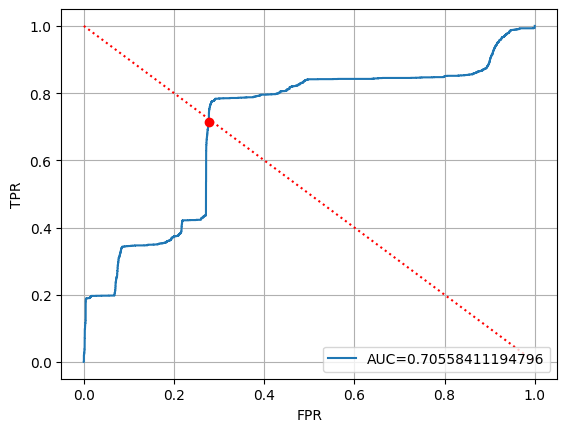

In [58]:
results=testing(model,test_loader)
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

threshold=ROC(y_test,y_pred)
